# 💡 Modelling for the NHS's ADHD Dataset

- Kindly load the preprocessed data (processed_data_final) from the EDA NoteBook to run the below Modelling codes.


There are 2 targets to predict namely,

1. ADHD diagnosis (0- None, 1- ADHD)
2. Sex_F (0- Male, 1 - Female)

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
pip install lime

In [29]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report,balanced_accuracy_score, recall_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import lime.lime_tabular

# Preprocessed Data Loading



- Training Data will be only used to fit the model to learn pattern.
- Validation Data will be only used to find the best hyperparameters for the respective models.
- Testing Data will be only used to predict the unseen data and to evaluate the performance of the respective model.


The data was splitted using the stratification on both ADHD and Sex_F. This distribution has equal distribution of both the ADHD classes and Sex_F classes. In another word, they have equal ratio on overall 4 classes.

Because of this distribtion, the models classification report can show the actual performance without any misleading.

In [30]:
with open('processed_data_final.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

X_train_final = loaded_data['X_train']
X_test_final = loaded_data['X_test']
X_val_final = loaded_data['X_val']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']
y_val = loaded_data['y_val']

In [31]:
X_train_final.shape, X_test_final.shape, X_val_final.shape, y_train.shape, y_test.shape, y_val.shape

((776, 30), (243, 30), (194, 30), (776, 2), (243, 2), (194, 2))

In [32]:
print("Training Data Class Distribution:")
print(y_train.value_counts().sort_index())

print("\nTesting Data Class Distribution:")
print(y_test.value_counts().sort_index())

print("\nValidation Data Class Distribution:")
print(y_test.value_counts().sort_index())

Training Data Class Distribution:
ADHD_Outcome  Sex_F
0             0        138
              1        107
1             0        371
              1        160
Name: count, dtype: int64

Testing Data Class Distribution:
ADHD_Outcome  Sex_F
0             0         43
              1         33
1             0        117
              1         50
Name: count, dtype: int64

Validation Data Class Distribution:
ADHD_Outcome  Sex_F
0             0         43
              1         33
1             0        117
              1         50
Name: count, dtype: int64


#  Model Proposal

### Naive Bayes

Naive Bayes is chosen for our ADHD classification task because it can give strong performance with limited training data and Its probabilistic approach works well with mixed feature types (neuroimaging data alongside categorical demographic information and numerical data). Moreover, the model's independence assumption, while simplistic, can be advantageous when dealing with the complex data like in our data.

### MLP
MLP is selected for our ADHD classification task becuase of its ability to model complex, non-linear relationships in the high-dimensional datasets such as neuroimaging and behavioral features. Moreover, its deep architecture, especially with hidden layers and non-linear activations, allows the model to learn patterns between ADHD symptoms and brain activity. Moreover, MLP's flexibility in tuning (e.g., hidden layer size, activation functions) makes it well-suited for capturing particular differences across ADHD and gender classifications.

### KNN
I wanted to try a tree based approach for simplicity and interpretability in our classification task. KNN performs well in detecting local patterns within the feature space and it is useful when class distinctions are based on similarity in brain imaging or behavioral features. KNN is non-parametric, meaning it makes no assumptions about the underlying data distribution. Since, the original dataset has uneven distributions, KNN looks like a good approach to test out. Additionally, KNN naturally adapts to multi-class and multi-output problems without requiring significant architectural changes.

In [1]:
def train_and_validate(model, param_grid, model_name):
    print(f"\nTraining {model_name}")

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    # Inner CV
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)

    # Outer CV
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    nested_scores = cross_val_score(grid_search, X_train_final, y_train, cv=outer_cv, scoring='accuracy', n_jobs=-1)

    print(f" Nested CV Accuracy for {model_name}: {nested_scores.mean():.4f} ± {nested_scores.std():.4f}")

    # Fitting on Train Set
    final_grid = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
    final_grid.fit(X_train_final, y_train)
    best_model = final_grid.best_estimator_

    print(f" Best params for {model_name}: {final_grid.best_params_}")

    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val_final)
    val_acc = accuracy_score(y_val, y_val_pred)

    print(f" Final Validation Accuracy for {model_name}: {val_acc:.4f}")
    for i, col in enumerate(['ADHD_Outcome', 'Sex_F']):
        print(f"\n{col} Report:")
        print(classification_report(y_val[col], y_val_pred[:, i]))

In [34]:
model_params = {
    'NaiveBayes': (GaussianNB(), {
        'clf__estimator__var_smoothing': [1e-9, 1e-8, 1e-7]
    }),

    'MLP': (MLPClassifier(max_iter=1000), {
        'clf__estimator__hidden_layer_sizes':[(50,), (100,), (100, 50)],
        'clf__estimator__alpha': [0.0001, 0.001],
        'clf__estimator__learning_rate_init': [0.001, 0.01],
        'clf__estimator__activation': ['relu', 'tanh'],
        'clf__estimator__solver': ['adam']
    }),

    'KNN': (KNeighborsClassifier(), {
        'clf__estimator__n_neighbors': [3, 5, 7],
        'clf__estimator__weights': ['uniform', 'distance']
    })
}

In [35]:
for name, (model, params) in model_params.items():
    wrapped_model = MultiOutputClassifier(model)
    train_and_validate(wrapped_model, params, name)

# Best params for NaiveBayes: {'clf__estimator__var_smoothing': 1e-09}
# Best params for MLP: {'clf__estimator__activation': 'tanh', 'clf__estimator__alpha': 0.001, 'clf__estimator__hidden_layer_sizes': (100,), 'clf__estimator__learning_rate_init': 0.001, 'clf__estimator__solver': 'adam'}
# Best params for KNN: {'clf__estimator__n_neighbors': 7, 'clf__estimator__weights': 'uniform'}


Training NaiveBayes
 Nested CV Accuracy for NaiveBayes: 0.4356 ± 0.0445
 Best params for NaiveBayes: {'clf__estimator__var_smoothing': 1e-09}
 Final Validation Accuracy for NaiveBayes: 0.4485

ADHD_Outcome Report:
              precision    recall  f1-score   support

           0       0.58      0.67      0.62        61
           1       0.84      0.77      0.80       133

    accuracy                           0.74       194
   macro avg       0.71      0.72      0.71       194
weighted avg       0.76      0.74      0.75       194


Sex_F Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       128
           1       0.38      0.32      0.35        66

    accuracy                           0.59       194
   macro avg       0.53      0.53      0.53       194
weighted avg       0.58      0.59      0.58       194


Training MLP
 Nested CV Accuracy for MLP: 0.4820 ± 0.0168
 Best params for MLP: {'clf__estimator__activation': 'tan

Based on the classification report from the models, I have decided to go with the MLP model because it has good overall performance, in terms of Precision, Recall and F1 Score for both cases. MLP can take care of FN cases, like mininzing the missed ADHD cases well. As based on the project nature, the ADHD performance plays a vital role. As for the Gender, MLP and NB has similar F1-scores. So, I have based my decision based on the ADHD improtance and selected MLP as the final model to fully train.

## Training Fully on the selected Model (MLP)

In [36]:
X_full_train = np.vstack([X_train_final, X_val_final])
y_full_train = np.vstack([y_train, y_val])

mlp_model = MLPClassifier(
    activation='tanh',
    alpha=0.001,
    hidden_layer_sizes=(100,),
    learning_rate_init=0.001,
    solver='adam',
    max_iter=1000,
    random_state=42
)

wrapped_mlp = MultiOutputClassifier(mlp_model)
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', wrapped_mlp)
])

pipe_mlp.fit(X_full_train, y_full_train)
y_test_pred = pipe_mlp.predict(X_test_final)

for i, label in enumerate(['ADHD_Outcome', 'Sex_F']):
    print(f"\n Classification Report for {label}:")
    print(classification_report(y_test[label], y_test_pred[:, i]))



 Classification Report for ADHD_Outcome:
              precision    recall  f1-score   support

           0       0.76      0.55      0.64        76
           1       0.82      0.92      0.87       167

    accuracy                           0.81       243
   macro avg       0.79      0.74      0.75       243
weighted avg       0.80      0.81      0.80       243


 Classification Report for Sex_F:
              precision    recall  f1-score   support

           0       0.72      0.82      0.76       160
           1       0.52      0.37      0.43        83

    accuracy                           0.67       243
   macro avg       0.62      0.60      0.60       243
weighted avg       0.65      0.67      0.65       243



# Conclusion

The Multi-Layer Perceptron (MLP) model give us the strong performance in classifying ADHD outcomes with overall accuracy of 81%. For the ADHD class (label 1), the model achieves a recall of 0.92. This shows that the model has ability to correctly identify patients with ADHD and results in very few false negatives. Additionally, it also maintains a high precision of 0.82 for this class, suggesting that most predictions labeled as ADHD are correct. While the recall for the non-ADHD class (label 0) is moderate at 0.55, the model still maintains a respectable F1-score of 0.64 for this group.

In addition to its strong performance on ADHD classification, the MLP model also provides moderate results for predicting Sex_F. The model achieves an overall accuracy of 67% on this task. It performs better at identifying males (label 0), with a recall of 0.82 and a precision of 0.72, meaning it correctly identifies most male instances and has relatively few false positives. As for  predicting females (label 1) model achieved a recall of  0.37 and a precision of 0.52. But, when compared to all other models, this MLP model was able to achieve a respectable performance of gender prediction.

Since, ADHD prediction is the main focus of the project, in general, we can conclude that the model has good performance in predicting the assigned patients's ADHD correctly.

# Lime (Local Interpretable Model-agnostic Explanations)

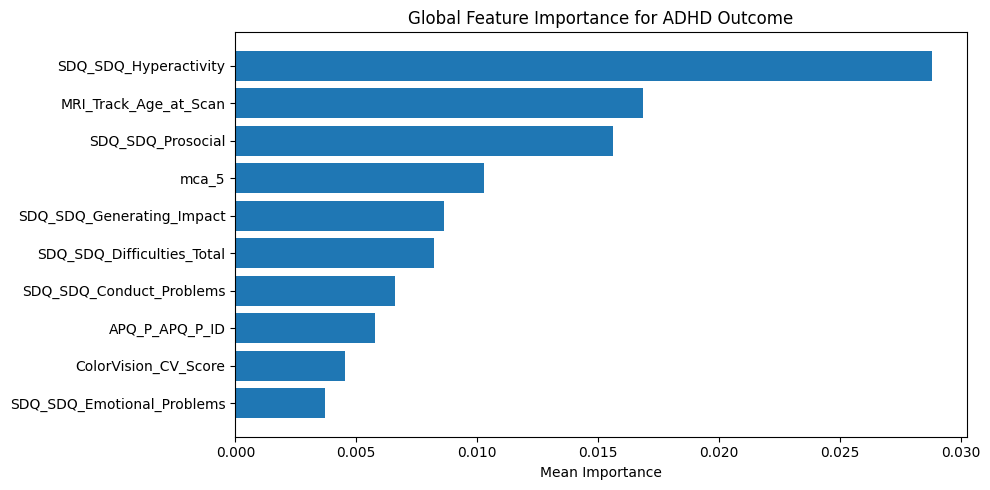

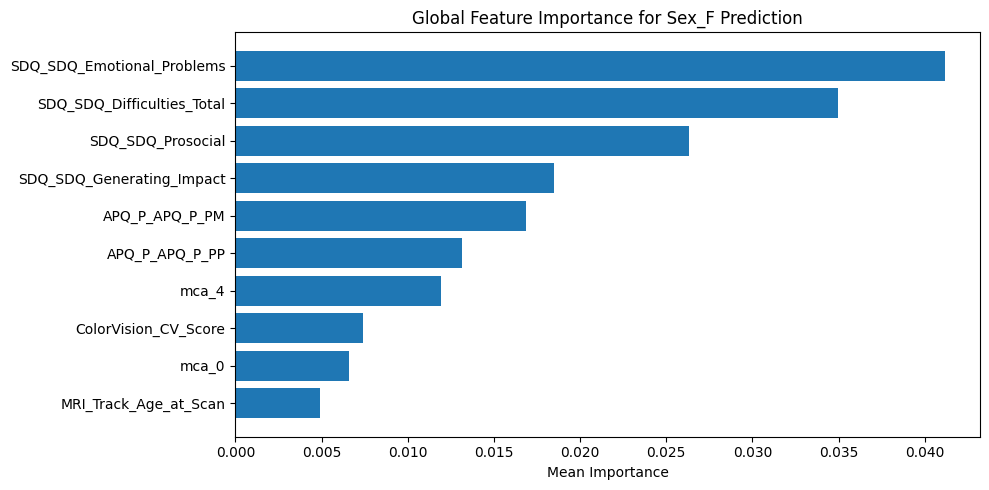

In [37]:
# GLOBAL FEATURE IMPORTANCE USING PERMUTATION IMPORTANCE

perm_adhd = permutation_importance(
    pipe_mlp.named_steps['clf'].estimators_[0],
    X_test_final,
    y_test['ADHD_Outcome'],
    scoring='accuracy',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
) # ADHD outcome feature importance

perm_sex = permutation_importance(
    pipe_mlp.named_steps['clf'].estimators_[1],
    X_test_final,
    y_test['Sex_F'],
    scoring='accuracy',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
) # Sex_F feature importance

def plot_perm_importance(perm_result, title):
    sorted_idx = perm_result.importances_mean.argsort()[::-1]
    top_features = X_test_final.columns[sorted_idx][:10]
    top_importances = perm_result.importances_mean[sorted_idx][:10]

    plt.figure(figsize=(10, 5))
    plt.barh(top_features[::-1], top_importances[::-1])
    plt.title(title)
    plt.xlabel("Mean Importance")
    plt.tight_layout()
    plt.show()

plot_perm_importance(perm_adhd, "Global Feature Importance for ADHD Outcome")
plot_perm_importance(perm_sex, "Global Feature Importance for Sex_F Prediction")

In overall, for ADHD, Strengthe and Difficulties features such as Hyperactivity, Prosocial, MRI Track_Age features are played the major role in ADHD predictions.

As for the gender prediction, the features such as Strength and Difficulties's Emotional Problem, Difficulties and Prosocial played the major role in Gender Prediction.

In [38]:
explainer_adhd = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['No ADHD', 'ADHD'],
    mode='classification',
    discretize_continuous=True
)

explainer_sex = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['Male', 'Female'],
    mode='classification',
    discretize_continuous=True
)

# Identify correct and incorrect prediction indices
adhd_correct_indices = (y_test_pred[:, 0] == y_test.iloc[:, 0]).to_numpy().nonzero()[0]
adhd_wrong_indices = (y_test_pred[:, 0] != y_test.iloc[:, 0]).to_numpy().nonzero()[0]

sex_correct_indices = (y_test_pred[:, 1] == y_test.iloc[:, 1]).to_numpy().nonzero()[0]
sex_wrong_indices = (y_test_pred[:, 1] != y_test.iloc[:, 1]).to_numpy().nonzero()[0]

idx_adhd_correct = adhd_correct_indices[17]
idx_adhd_wrong = adhd_wrong_indices[0]

idx_sex_correct = sex_correct_indices[0]
idx_sex_wrong = sex_wrong_indices[0]

sample_adhd_correct = X_test_final.iloc[idx_adhd_correct].values
sample_adhd_wrong = X_test_final.iloc[idx_adhd_wrong].values

sample_sex_correct = X_test_final.iloc[idx_sex_correct].values
sample_sex_wrong = X_test_final.iloc[idx_sex_wrong].values


In [39]:
len(sex_correct_indices)

162

In [40]:
# ADHD Correct
adhd_exp_correct = explainer_adhd.explain_instance(
    sample_adhd_correct,
    pipe_mlp.named_steps['clf'].estimators_[0].predict_proba,
    num_features=10
)
print(f"\n ADHD - Correct Prediction (Index: {idx_adhd_correct})")
adhd_exp_correct.show_in_notebook()


 ADHD - Correct Prediction (Index: 18)


For this particular test case, the fatures in oranges are influenced mainly for the prediction of ADHD and for the Non-ADHD blue ones are used.

In [41]:
# Sex_F Correct Prediction
sex_exp_correct = explainer_sex.explain_instance(
    sample_sex_correct,
    pipe_mlp.named_steps['clf'].estimators_[1].predict_proba,
    num_features=10
)
print(f"\n Sex_F - Correct Prediction (Index: {idx_sex_correct})")
sex_exp_correct.show_in_notebook()


 Sex_F - Correct Prediction (Index: 0)


The features with their respected color demonstrate the pillar behind consideration for prediction by the model.

In [42]:
female_correct_indices = ((y_test_pred[:, 1] == 1) & (y_test.iloc[:, 1] == 1)).to_numpy().nonzero()[0]
idx_female_correct = female_correct_indices[21]
sample_female_correct = X_test_final.iloc[idx_female_correct].values
sex_female_exp = explainer_sex.explain_instance(
    sample_female_correct,
    pipe_mlp.named_steps['clf'].estimators_[1].predict_proba,
    num_features=10
)
print(f"\n Sex_F - Correctly Predicted as Female (Index: {idx_female_correct})")
sex_female_exp.show_in_notebook()



 Sex_F - Correctly Predicted as Female (Index: 168)


The features with their respected color demonstrate the pillar behind consideration for prediction by the model.

# Some Visualization for Presentation

In [43]:
def plot_classification_metrics(y_true, y_pred, model_name, target_names=['ADHD_Outcome', 'Sex_F']):
    for i, col in enumerate(target_names):
        report = classification_report(y_true[col], y_pred[:, i], output_dict=True)
        df = pd.DataFrame(report).transpose()
        df = df.loc[['0', '1']]

        plt.figure(figsize=(8, 5))
        ax = df[['precision', 'recall', 'f1-score']].plot(kind='bar')
        plt.title(f'{model_name} - {col} Metrics')
        plt.ylabel('Score')
        plt.ylim(0, 1.1)
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(loc='lower right')
        plt.tight_layout()

        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height:.2f}',
                        (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=9, color='black')

        plt.show()

In [44]:
def evaluate_model(model_name, y_true, y_pred, target_names=['ADHD_Outcome', 'Sex_F']):
    print(f"\n {model_name} Evaluation")
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy (Exact Match): {overall_accuracy:.4f}")

    print("\nClassification Report (Per Target):")
    for i, col in enumerate(target_names):
        print(f"\n{col} Report:")
        print(classification_report(y_true[col], y_pred[:, i]))


 MLP Classifier Evaluation
Overall Accuracy (Exact Match): 0.5391

Classification Report (Per Target):

ADHD_Outcome Report:
              precision    recall  f1-score   support

           0       0.76      0.55      0.64        76
           1       0.82      0.92      0.87       167

    accuracy                           0.81       243
   macro avg       0.79      0.74      0.75       243
weighted avg       0.80      0.81      0.80       243


Sex_F Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.76       160
           1       0.52      0.37      0.43        83

    accuracy                           0.67       243
   macro avg       0.62      0.60      0.60       243
weighted avg       0.65      0.67      0.65       243



<Figure size 800x500 with 0 Axes>

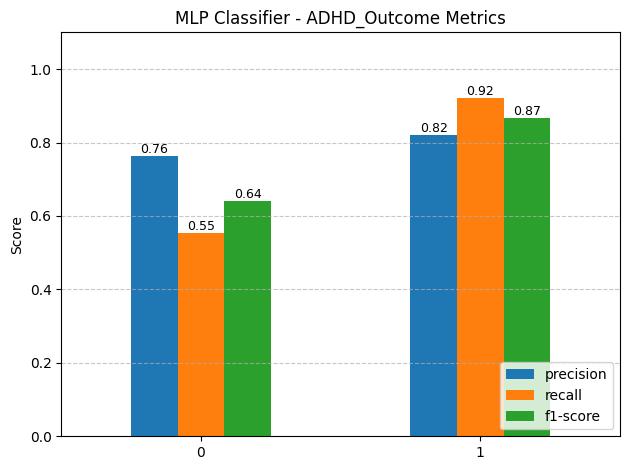

<Figure size 800x500 with 0 Axes>

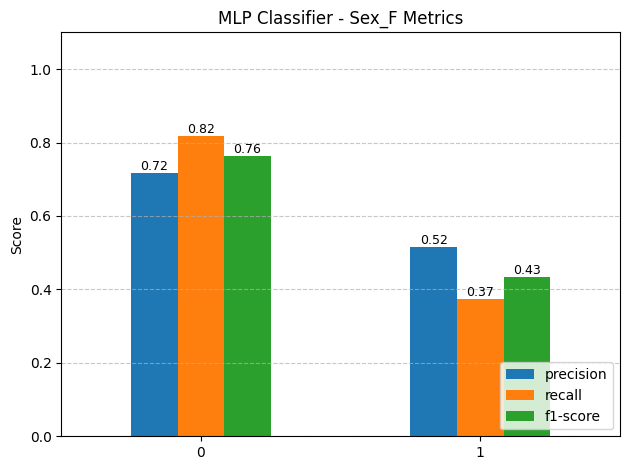

In [45]:
y_pred = pipe_mlp.predict(X_test_final)
evaluate_model("MLP Classifier", y_test, y_pred)
plot_classification_metrics(y_test, y_pred, "MLP Classifier")

According to the Metrics, the ADHD prediction is good but for the Gender (Sex_F), it is decent. The model is still struggling to perform well on the Female patients.

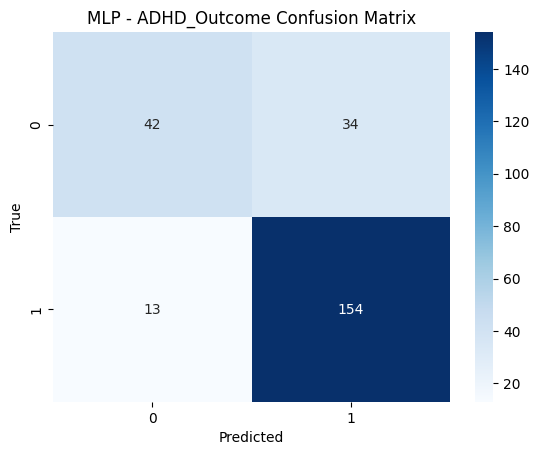

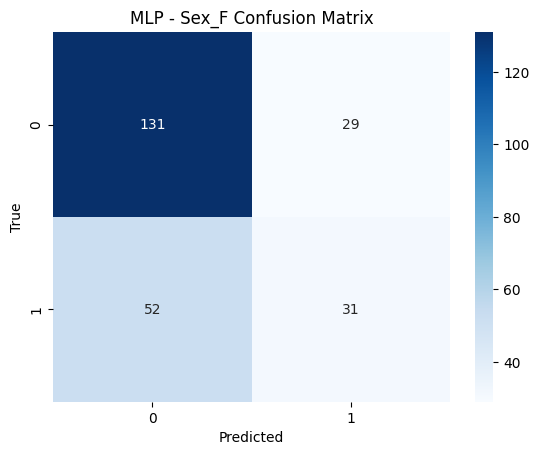

In [46]:
def plot_confusion(y_true, y_pred, label, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - {label} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

for i, col in enumerate(['ADHD_Outcome', 'Sex_F']):
    plot_confusion(y_test[col], y_pred[:, i], label=col, model_name='MLP')

- For ADHD
True Negatives (TN): 42 cases are correctly predicted as not having ADHD (0)

False Positives (FP): 34 cases are incorrectly predicted as having ADHD when they don't

False Negatives (FN): 13 cases are incorrectly predicted as not having ADHD when they do

True Positives (TP): 154 cases are correctly predicted as having ADHD (1)

Based on this findings, even though the model is predicting “Healthy” individuals as having ADHD, this is less risky than other way round.


- For Sex_F

True Negatives (TN): 131 cases are correctly predicted as not female (0)

False Positives (FP): 29 cases are incorrectly predicted as female when they're not

False Negatives (FN): 52 cases are incorrectly predicted as not female when they are

True Positives (TP): 31 cases are correctly predicted as female (1)

Based on this findings, the model patient’s gender often. Mostly for Female than for the Male.  


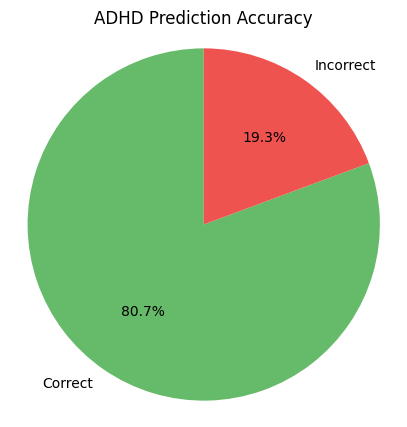

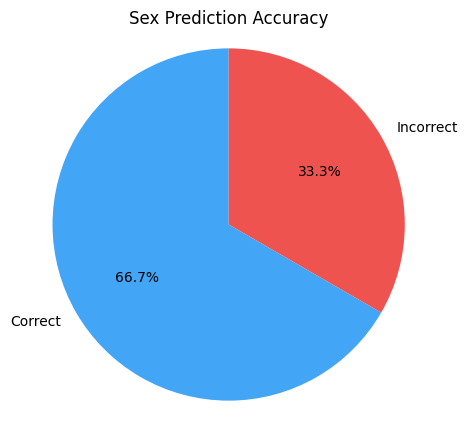

In [47]:
adhd_correct = (y_test['ADHD_Outcome'] == y_pred[:, 0]).sum()
adhd_total = len(y_test)
adhd_incorrect = adhd_total - adhd_correct

sex_correct = (y_test['Sex_F'] == y_pred[:, 1]).sum()
sex_total = len(y_test)
sex_incorrect = sex_total - sex_correct

# ADHD
plt.figure(figsize=(5, 5))
plt.pie([adhd_correct, adhd_incorrect],
        labels=['Correct', 'Incorrect'],
        autopct='%1.1f%%',
        colors=['#66bb6a', '#ef5350'],
        startangle=90)
plt.title('ADHD Prediction Accuracy')
plt.axis('equal')
plt.show()

# Sex
plt.figure(figsize=(5, 5))
plt.pie([sex_correct, sex_incorrect],
        labels=['Correct', 'Incorrect'],
        autopct='%1.1f%%',
        colors=['#42a5f5', '#ef5350'],
        startangle=90)
plt.title('Sex Prediction Accuracy')
plt.axis('equal')
plt.show()


# Conclusion
- The model is able to achieve the 81% accuracy in predicting the ADHD and 67% on predicting the gender as also mentioned via pie chart.
- In real world, the model does not show bias towards the ADHD predicition. However, the model has bias on predicting the Sex_F, especially the Female.



The Modle can be applied to the NHS but not as a standard one but for a demo. Until a better one is acheived by utilizing more features realated to ADHD and more data samples, this one can be used.